In [131]:
import datetime, urllib, re, math, json, requests
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

In [3]:
#* constants



#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

# real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [4]:
df = pd.read_csv("http://blog.lazd.net/coronadatascraper/data.csv",parse_dates=True)
dataCS =df.set_index(["city","county","state","country"])


#use index slice for more easy/clean access
idx = pd.IndexSlice

IClmns= idx["cases","death","recovered","tested",'url']


ctrMask = dataCS["cases"] > 1000
dataCS.loc[idx[:,:, :, ctrMask],:]

cases  deaths  recovered  tested  \
city county state          country                                     
NaN  NaN    NaN            DEU       5795    11.0       46.0     NaN   
                           ITA      24747  1809.0     2335.0     NaN   
                           SWE       1022     3.0        1.0     NaN   
                           ESP       7798   289.0      517.0     NaN   
                           CHE       2200    14.0        4.0     NaN   
                           NOR       1221     3.0        1.0     NaN   
                           NLD       1135    20.0        2.0     NaN   
            Hubei          CHN      67794  3085.0    54288.0     NaN   
            NaN            IRN      13938   724.0     4590.0     NaN   
                           KOR       8162    75.0      510.0     NaN   
            Guangdong      CHN       1360     8.0     1304.0     NaN   
            Henan          CHN       1273    22.0     1250.0     NaN   
            Zhejiang       CHN       1231     1.0     1211.0     NaN   
            Hunan          CHN       1018     4.0     1014.0     NaN   
            Emilia-Romagna ITA       3093   284.0       68.0     NaN   
            Lombardia      ITA      13272  1218.0     2011.0     NaN   
            Marche         ITA       1133    46.0        0.0     NaN   
            Piemonte       ITA       1111    81.0        0.0     NaN   
            Veneto         ITA       2172    63.0      120.0     NaN   

                                          lat        long  \
city county state          country                          
NaN  NaN    NaN            DEU      51.099245   10.473758   
                           ITA      41.826062   12.560077   
                           SWE      62.191185   17.635631   
                           ESP      35.738471   -6.849639   
                           CHE      46.840811    8.258984   
                           NOR      69.255255   18.013723   
                           NLD      52.105283    5.272003   
            Hubei          CHN      31.166405  112.263928   
            NaN            IRN      32.412651   53.663112   
                           KOR      35.912360  127.856985   
            Guangdong      CHN      22.876784  113.417924   
            Henan          CHN      33.877080  113.484422   
            Zhejiang       CHN      29.189050  120.164136   
            Hunan          CHN      27.369415  111.509091   
            Emilia-Romagna ITA      43.962721   12.428037   
            Lombardia      ITA      45.832509    8.812033   
            Marche         ITA      43.701371   12.686513   
            Piemonte       ITA      46.111308    8.289297   
            Veneto         ITA      46.278185   12.220946   

                                                                                  url  \
city county state          country                                                      
NaN  NaN    NaN            DEU             https://github.com/CSSEGISandData/COVID-19   
                           ITA             https://github.com/CSSEGISandData/COVID-19   
                           SWE             https://github.com/CSSEGISandData/COVID-19   
                           ESP             https://github.com/CSSEGISandData/COVID-19   
                           CHE             https://github.com/CSSEGISandData/COVID-19   
                           NOR             https://github.com/CSSEGISandData/COVID-19   
                           NLD             https://github.com/CSSEGISandData/COVID-19   
            Hubei          CHN             https://github.com/CSSEGISandData/COVID-19   
            NaN            IRN             https://github.com/CSSEGISandData/COVID-19   
                           KOR             https://github.com/CSSEGISandData/COVID-19   
            Guangdong      CHN             https://github.com/CSSEGISandData/COVID-19   
            Henan          CHN             https://github.com/CSSEGISandData/COVID-1

In [169]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
dataCS.loc[(np.nan, "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "CA", "USA"],IClmns]
#total cases in ca
dataCS.loc[idx[np.nan, np.nan, "CA", "USA"],:]["cases"]
display(HTML(dataCS.loc[idx[:, :, "CA", "USA"],IClmns].to_html()))

dataCS.loc[idx[:, "San Diego County", "CA", "USA"],["url"]].values

array([['https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html']],
      dtype=object)

# CDC Data is here:

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [163]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()



# john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## githunb 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [96]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids, set Na for np.NaN (very annoying)
df["Province/State"]=df["Province/State"].fillna("NA")
df =df.set_index(["Country/Region","Lat","Long","Province/State"])


df.columns = pd.to_datetime(df.columns,format="%m/%d/%y")

dt = df.columns[-1]
print(dt)
if sum(df[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=dt)
else:
    data = df
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"]
print(noChin)
data.loc["NoChina",np.NaN,np.NaN,"NA"]=data.loc[(noChin)].sum()    
data.loc[("Europe",np.NaN,np.NaN,"NA")]=data.loc[euro].sum()    
# note this is an over-estimate
data.loc[("USAll",np.NaN,np.NaN,"NA")]=data.loc["US"].sum()    

data.loc[("ChinaAll",np.NaN,np.NaN,"NA")]=data.loc["China"].sum()  



2020-03-16 00:00:00
Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       ...
       'Turkey', 'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'occupied Palestinian territory'],
      dtype='object', name='Country/Region', length=155)


In [8]:
# create new groups
# dont use string for UR, but the 50 states

northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Europe":"Europe",            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


In [164]:

#data.loc["Italy"][dt]
data[dt]# get last row
data[data[dt]>1000].sort_values("Country/Region").iloc[:,-5:]


2020-03-12  2020-03-13  \
Country/Region Lat     Long      Province/State                           
Austria        47.5162  14.5501  NA                     302         504   
Belgium        50.8333  4.0000   NA                     314         559   
China          27.6104  111.7088 Hunan                 1018        1018   
               29.1832  120.0934 Zhejiang              1215        1215   
               33.8820  113.6140 Henan                 1273        1273   
               23.3417  113.4244 Guangdong             1356        1356   
               30.9756  112.2707 Hubei                67781       67786   
ChinaAll       NaN     NaN       NA                   80932       80945   
Europe         NaN     NaN       NA                   21379       33891   
France         46.2276  2.2137   France                2281        3661   
Germany        51.0000  9.0000   NA                    2078        3675   
Iran           32.0000  53.0000  NA                   10075       11364   
Italy          43.0000  12.0000  NA                   12462       17660   
Korea, South   36.0000  128.0000 NA                    7869        7979   
Netherlands    52.1326  5.2913   Netherlands            503         804   
NoChina        NaN     NaN       NA                   47411       64248   
Norway         60.4720  8.4689   NA                     702         996   
Spain          40.0000 -4.0000   NA                    2277        5232   
Sweden         63.0000  16.0000  NA                     599         814   
Switzerland    46.8182  8.2275   NA                     652        1139   
USAll          NaN     NaN       NA                    1663        2179   
United Kingdom 55.3781 -3.4360   United Kingdom         456         798   

                                                 2020-03-14  2020-03-15  \
Country/Region Lat     Long      Province/State                           
Austria        47.5162  14.5501  NA                     655         860   
Belgium        50.8333  4.0000   NA                     689         886   
China          27.6104  111.7088 Hunan                 1018        1018   
               29.1832  120.0934 Zhejiang              1227        1231   
               33.8820  113.6140 Henan                 1273        1273   
               23.3417  113.4244 Guangdong             1356        1360   
               30.9756  112.2707 Hubei                67790       67794   
ChinaAll       NaN     NaN       NA                   80977       81003   
Europe         NaN     NaN       NA                   41036       48642   
France         46.2276  2.2137   France                4469        4499   
Germany        51.0000  9.0000   NA                    4585        5795   
Iran           32.0000  53.0000  NA                   12729       13938   
Italy          43.0000  12.0000  NA                   21157       24747   
Korea, South   36.0000  128.0000 NA                    8086        8162   
Netherlands    52.1326  5.2913   Netherlands            959        1135   
NoChina        NaN     NaN       NA                   75120       86446   
Norway         60.4720  8.4689   NA                    1090        1221   
Spain          40.0000 -4.0000   NA                    6391        7798   
Sweden         63.0000  16.0000  NA                     961        1022   
Switzerland    46.8182  8.2275   NA                    1359        2200   
USAll          NaN     NaN       NA                    2727        3499   
United Kingdom 55.3781 -3.4360   United Kingdom        1140        1140   

                                                 2020-03-16  
Country/Region Lat     Long      Province/State              
Austria        47.5162  14.5501  NA                    1018  
Belgium        50.8333  4.0000   NA                    1058  
China          27.6104  111.7088 Hunan                 1018  
               29.1832  120.0934 Zhejiang              1231  
               33.8820  113.6140 Henan                 1273  
             

Growth Rate NoChina:1.15
Growth Rate China:1.06
Growth Rate Korea, South:1.11
Growth Rate Europe:1.18


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\scimath.py:310: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)


<Figure size 1200x800 with 0 Axes>

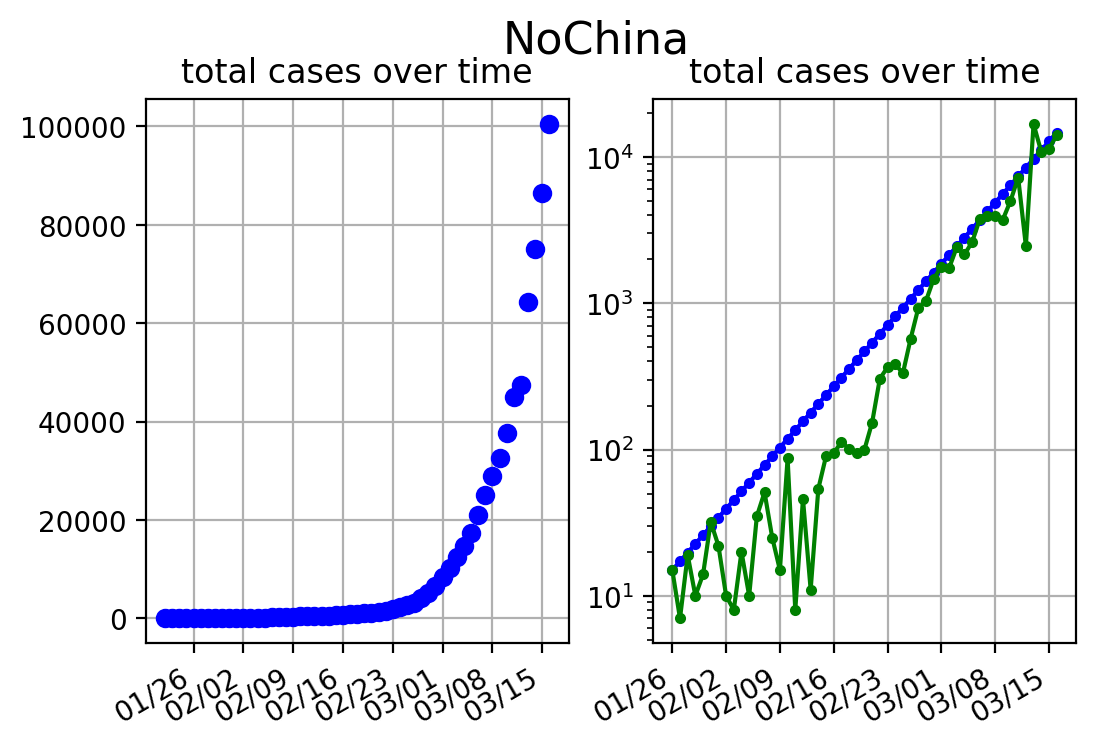

<Figure size 1200x800 with 0 Axes>

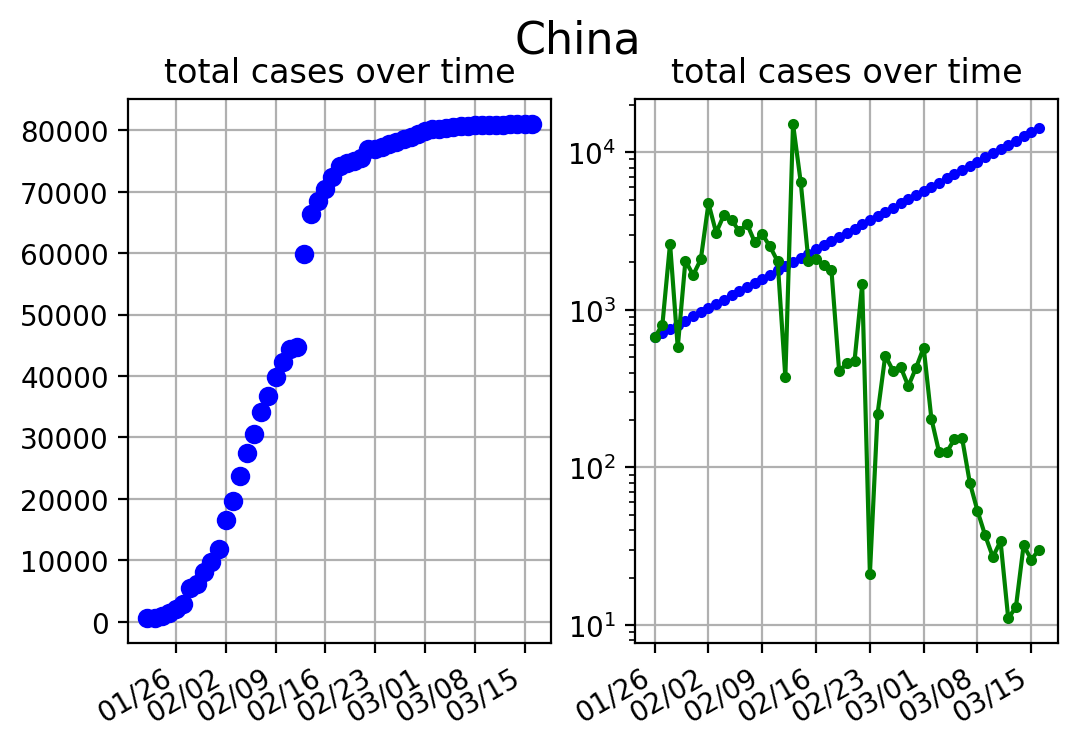

<Figure size 1200x800 with 0 Axes>

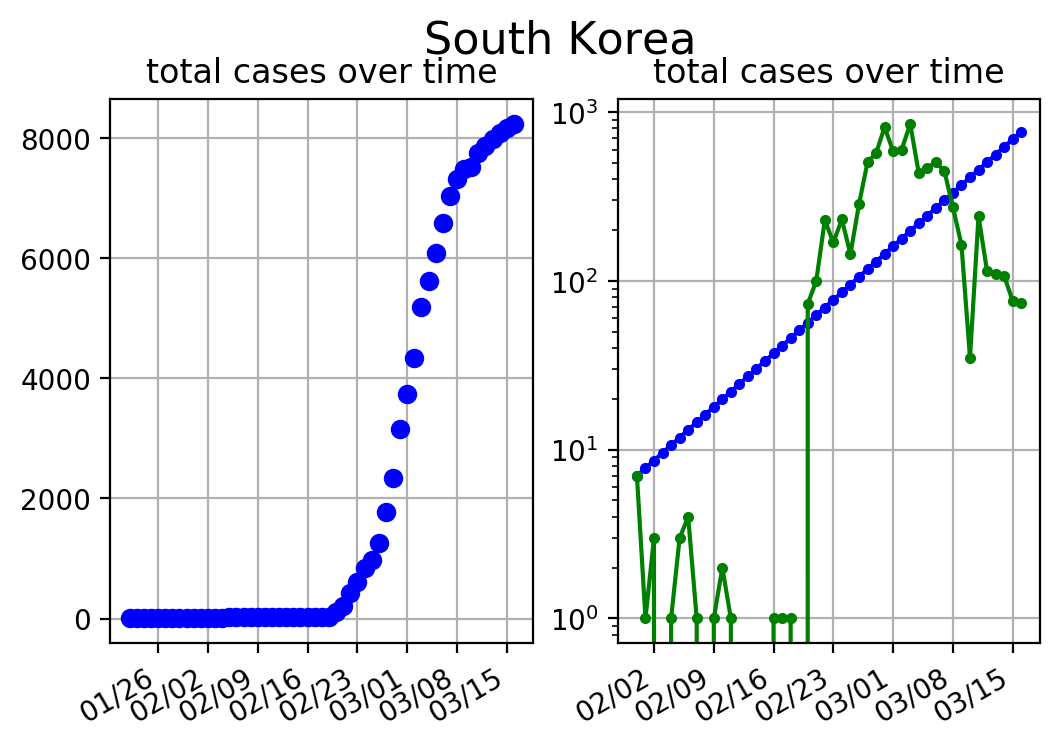

<Figure size 1200x800 with 0 Axes>

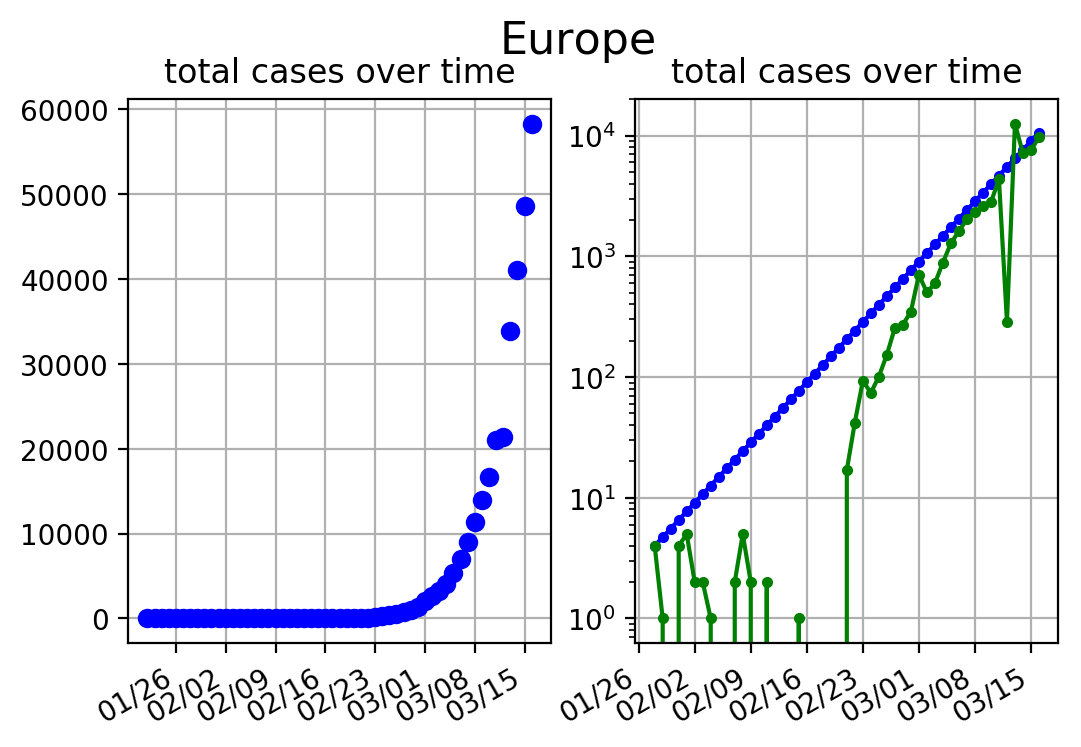

In [10]:
#assume (1+E*P) is 120%


#determine slope and plot
for name in ["NoChina","China", "South Korea", "Europe"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    ax[1].grid()
#    ax[1].legend()
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].set_title("total cases over time");

    fig.autofmt_xdate()
    
    #---
    y=data.loc[ctr].sum()
    ax[0].plot_date(y.index,y.values)        
    ax[0].grid()
#    ax[0].legend()
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].set_title("total cases over time");

    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


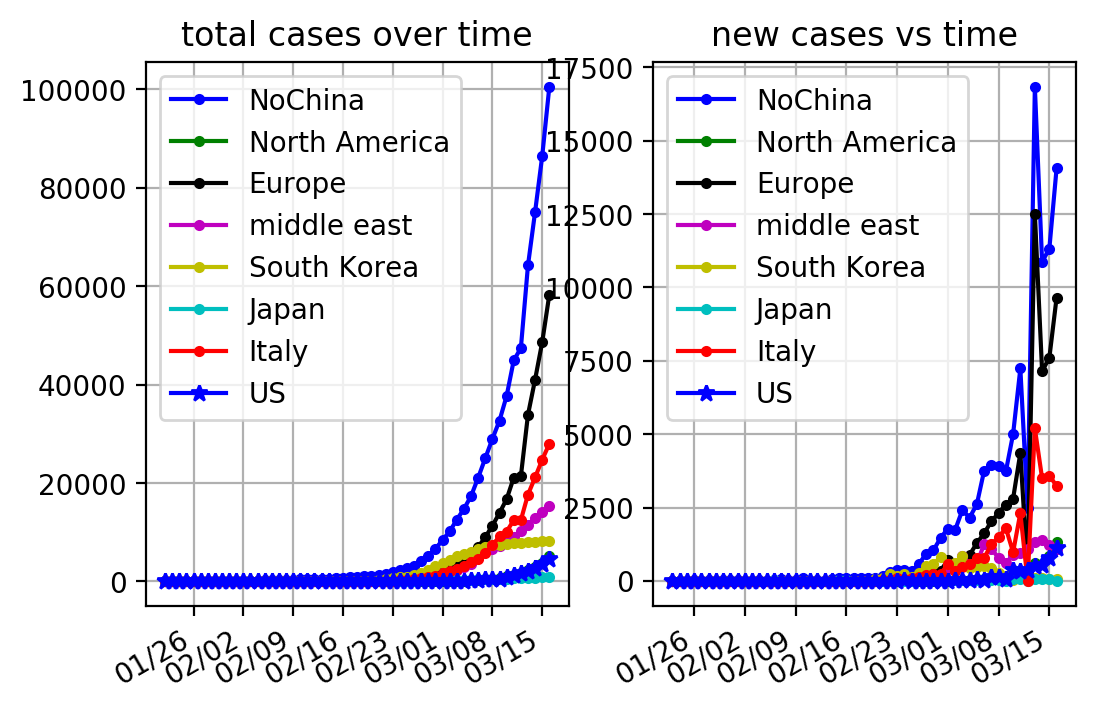

In [11]:

#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    y = data.loc[(country)].sum()
    ax[0].plot(y.index,y.values,label=name)
#ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].xaxis.set_major_locator(myLocator)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals,label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].legend()
ax[1].set_title("new cases vs time");

fig.autofmt_xdate()



# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

[ The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far. ]


A3date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


<Figure size 1200x800 with 0 Axes>

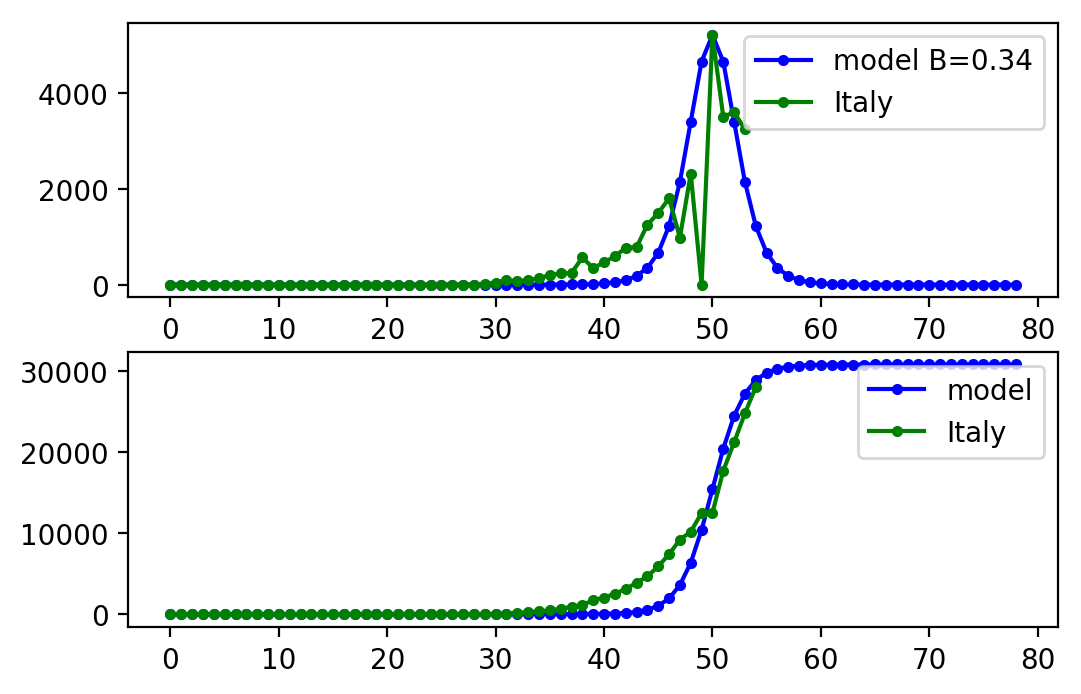

<Figure size 1200x800 with 0 Axes>

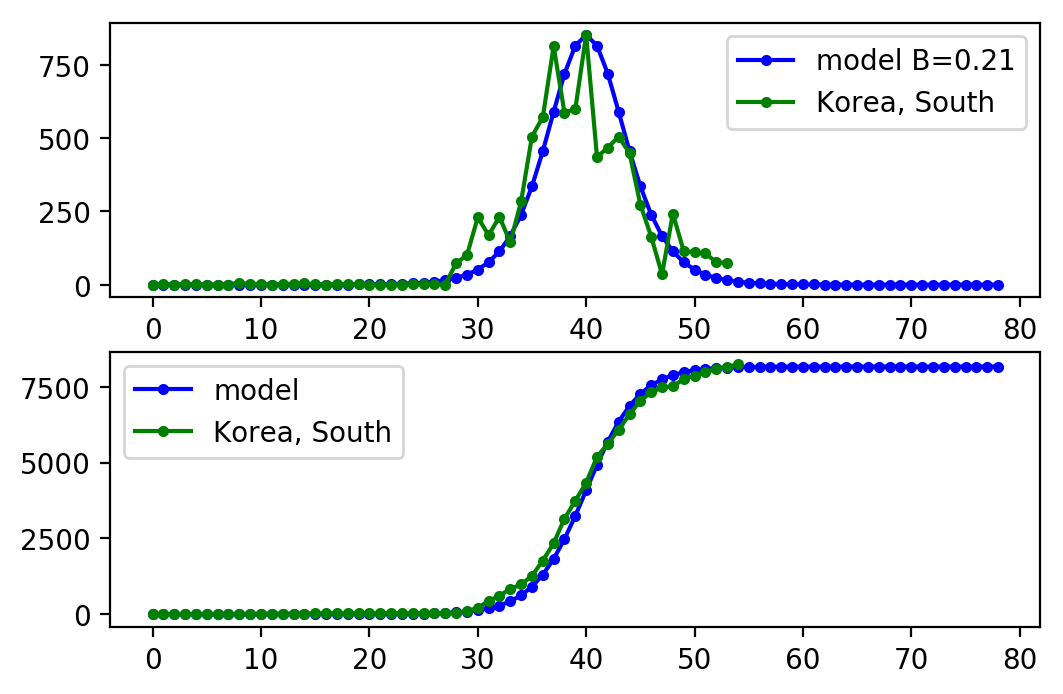

<Figure size 1200x800 with 0 Axes>

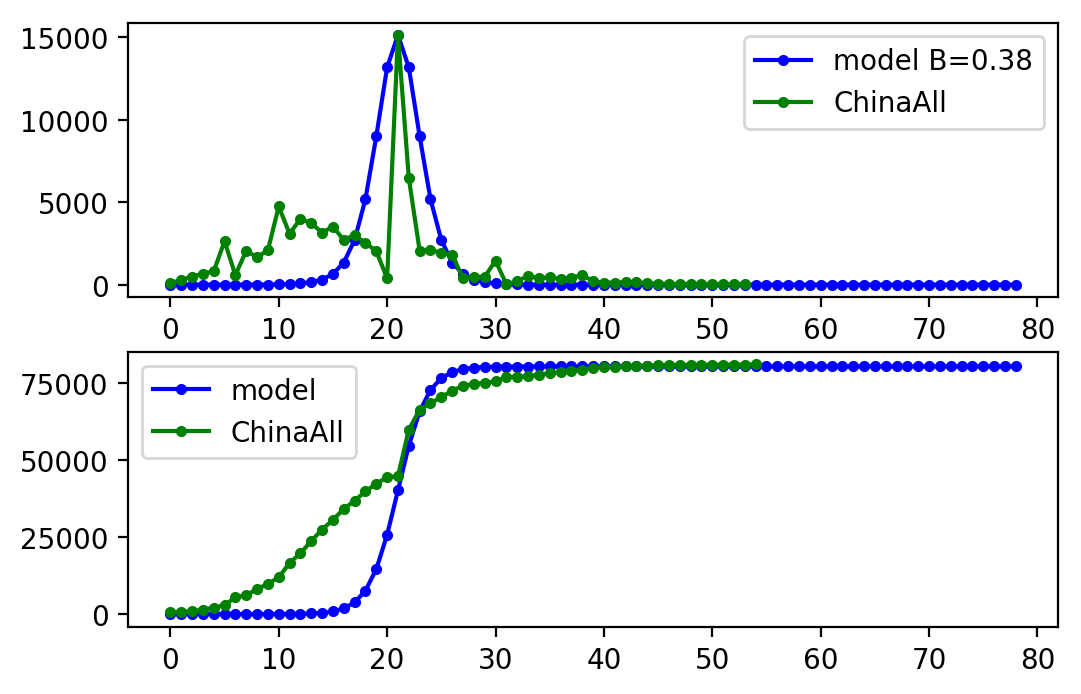

<Figure size 1200x800 with 0 Axes>

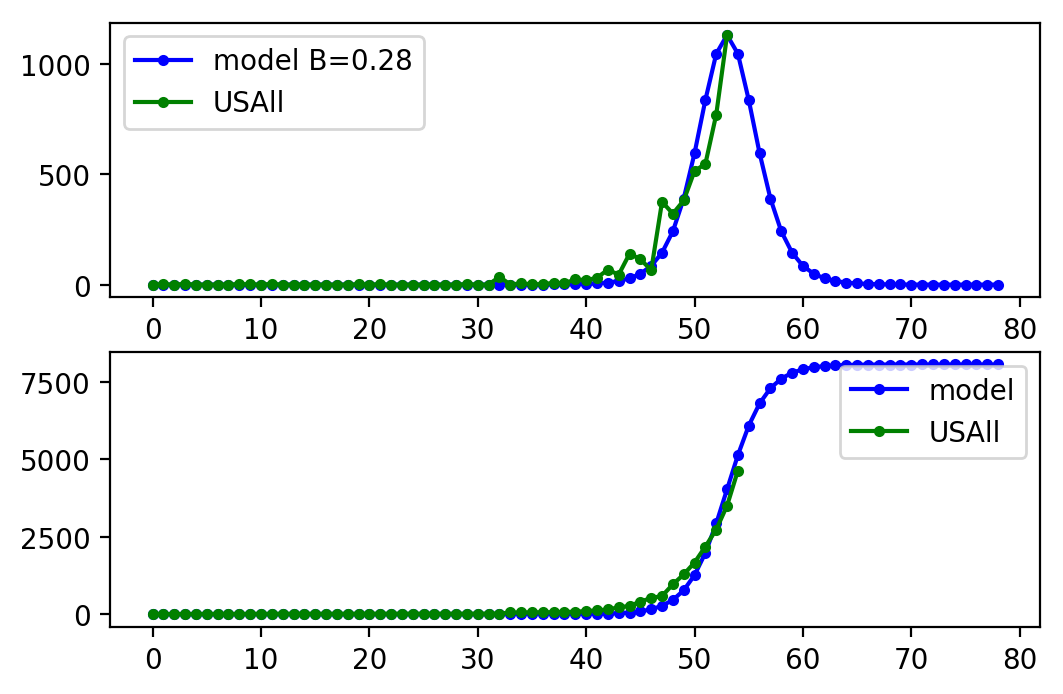

<Figure size 1200x800 with 0 Axes>

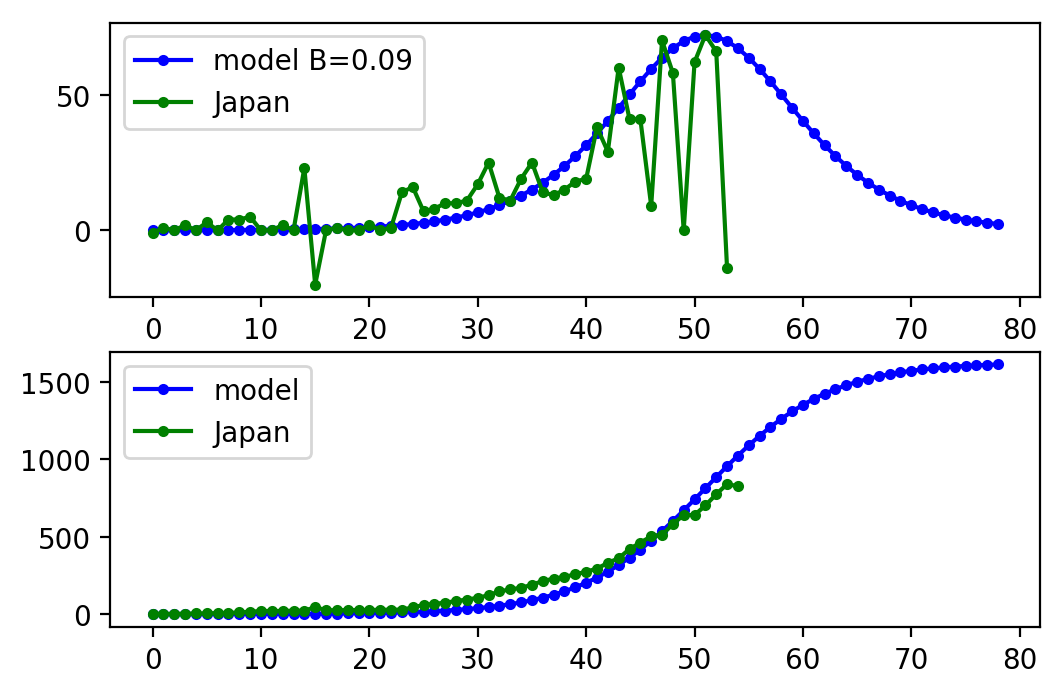

<Figure size 1200x800 with 0 Axes>

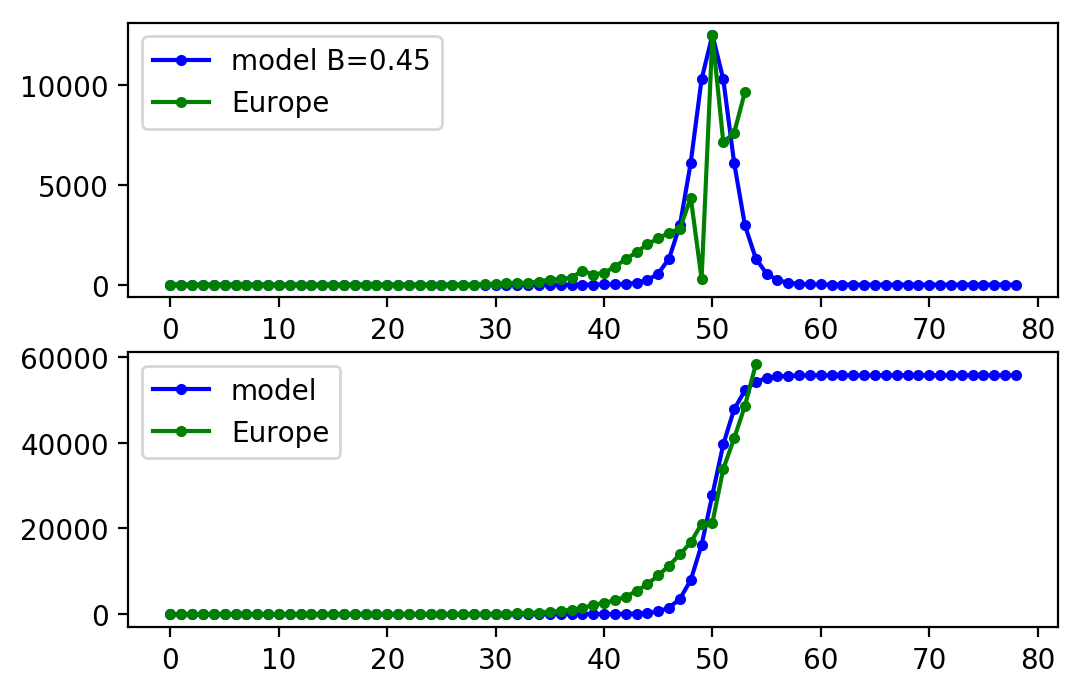

In [161]:
# place a model on all countries with high counts

#filtV = "US"
#filtV = "Italy"
#filtV = "China"
#for ctr in countries.keys():
    #only get filtered country or group, from countries dict
    #if any([v == ctr for v in filtV ]): continue
    
#g = data[data.loc[(slice(None),slice(None),slice(None),"NA"),dt]>1000]
#print(g)
#print(ctr)
ctrs= ["Italy","Korea, South","ChinaAll","USAll","Japan","Europe"]
for ctr in ctrs:
    plt.figure()
    # get daily change, drop first value, '0'
    v = data.loc[ctr].sum().diff().values[1:]
    y = data.loc[ctr].sum().values
    
    #A/C are derived, 
    A=max(v)
    C=np.argmax(v)
    # this is width variable, smaller means slower groth (this is a guss)
    # first run wiht a good set then adjust to target (for example run with south kora)
    def model(t,A,C,B):    
        return A/B * ( np.tanh( B * (t-C)) + 1 )
    f = lambda t,B: model(t, A, C,B)
    t = np.arange(0,sp.size(y))
    params, params_covariance = optimize.curve_fit(f, t, y,
                                               p0=[.2])
    
    B=params[0]
     
    

    # must be in days
    N=sp.size(v)
    t = np.arange(0,N+25)
    yh = A/B * ( np.tanh( B * (t-C)) + 1 )

    vh = A/(np.cosh( B * (t-C))**2)
    fig, ax = plt.subplots(2,1,)
    ax[0].plot(vh,label="model B=%.2f" % B)
    ax[0].plot(v,label=ctr)
    ax[0].legend()
    
    ax[1].grid()
    ax[1].plot(yh,label="model")
    
    ax[1].plot(y,label=ctr)
    
    ax[1].grid()
    ax[1].legend()
    

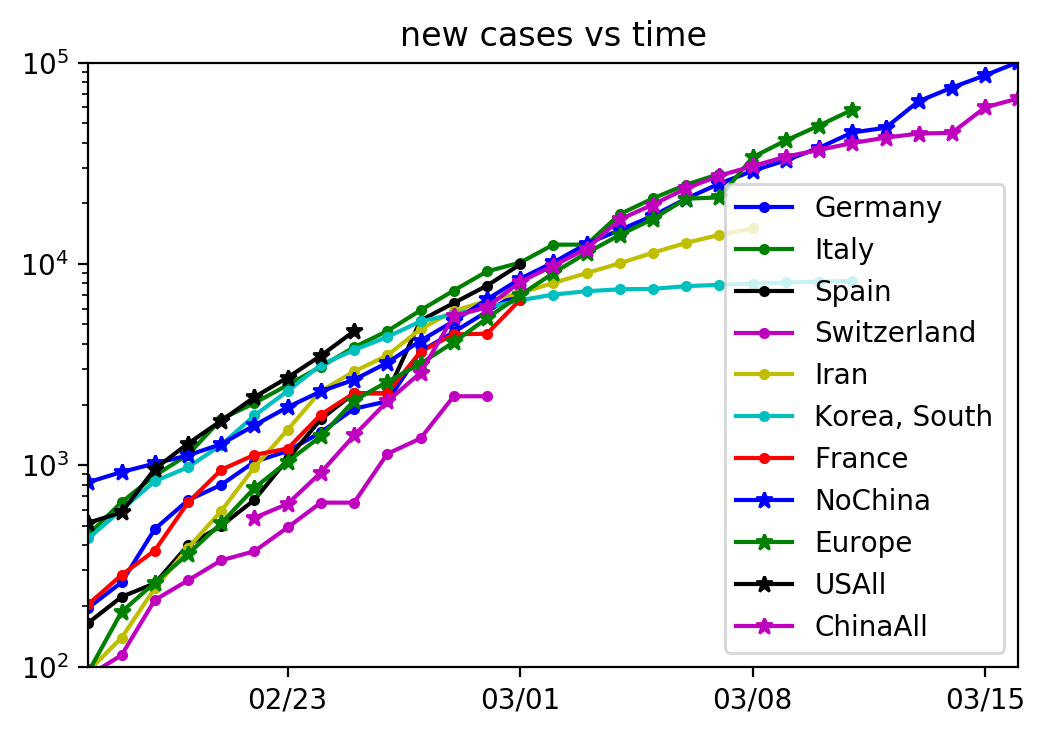

In [166]:
#align countries, with the following offset to get a prediction where they are 
# ideally normalize too

offsets = {"ChinaAll":31,
           "Italy":-9,
           "Spain":-15,
           "Iran":-8,
           "Germany":-15,
           "Korea, South":-5,
           "Switzerland":-16,
           "France":-15,
           "NoChina":0,
           "Europe":-5,
           "Norway":-20,
           "United Kingdom":-20,
           "USAll":-20}


                  


#plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgbcmyk') +"
#                                   "cycler('lw', [1, 1, 3])")
                  
fig, ax=plt.subplots(1,1)
for index, row in data[data[dt]>2000].iterrows():
    ctr =index[0]
    #print(ctr)
    if("China" == ctr): continue
    
    vdt = [(d +datetime.timedelta(days=offsets[ctr])).date()#.strftime("%m/%d")
           for d in data.columns]
    
    ax.semilogy(vdt,row.values, label=ctr)
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
#control range to zoom regio of interest
ax.set_ylim(1e2, 1e5)
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today())
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("new cases vs time");



2020-02-25 00:00:00


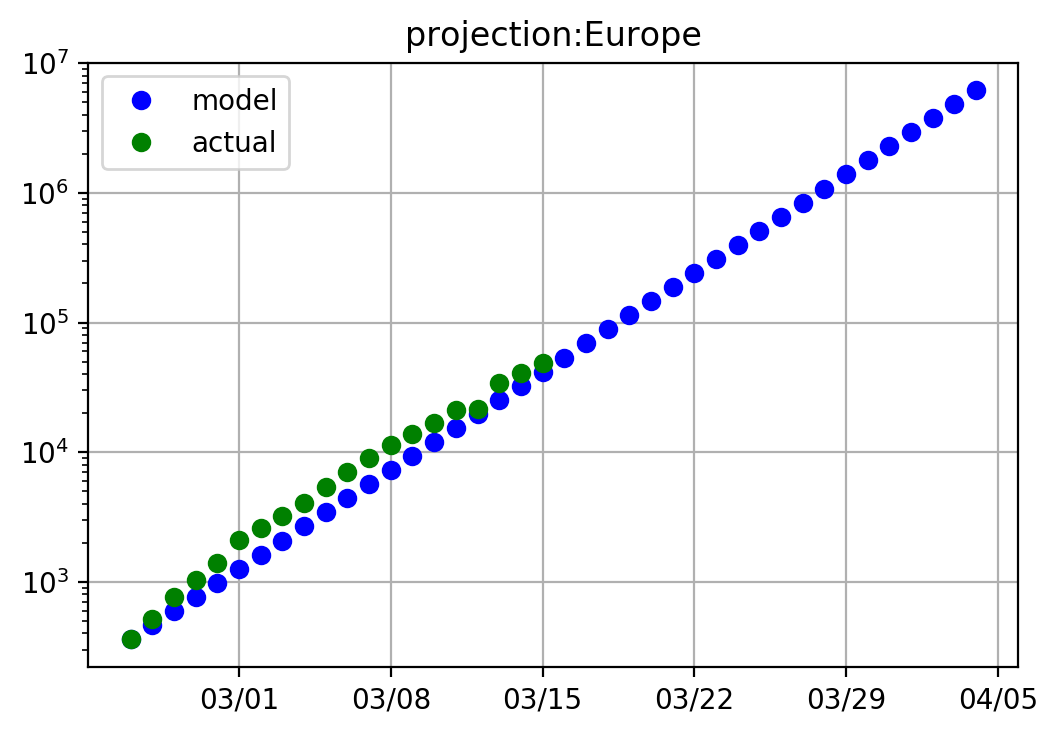

In [47]:
# try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# https://en.wikipedia.org/wiki/Generalised_logistic_function
# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .25
ctr       = "Europe"
caseMin   = 300
TN        = 21     # number of intervals after today



s = data.loc[ctr].sum()
startDate = s[s>caseMin].index[0]

print(startDate)

#nmber of intervals
N  = sp.size(data.columns)


# Set the epoch value
Y0 = data[startDate][ctr].sum()
#determine time offset
offset = (data.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-data.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")



ax.plot_date(x[:(offset+NE)],
             data.loc[ctr,startDate:].sum(),
             label="actual")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr)
#ax.set_ylim(0, 50000)
plt.yscale('log')



             model    cdc     jhu
2020-02-27    1290  258.0    58.0
2020-02-28    1454  308.0    60.0
2020-02-29    1639  355.0    68.0
2020-03-01    1848  421.0    74.0
2020-03-02    2084  489.0    98.0
2020-03-03    2350  560.0   118.0
2020-03-04    2650  631.0   149.0
2020-03-05    2988  688.0   217.0
2020-03-06    3369  745.0   262.0
2020-03-07    3798  799.0   402.0
2020-03-08    4282  850.0   518.0
2020-03-09    4829  920.0   583.0
2020-03-10    5444  956.0   959.0
2020-03-11    6138  981.0  1281.0
2020-03-12    6921  985.0  1663.0
2020-03-13    7804  987.0  2179.0
2020-03-14    8799  989.0  2727.0
2020-03-15    9920  991.0  3499.0
2020-03-16   11185    NaN  4632.0
2020-03-17   12611    NaN     NaN
2020-03-18   14219    NaN     NaN
2020-03-19   16032    NaN     NaN
2020-03-20   18077    NaN     NaN
2020-03-21   20381    NaN     NaN
2020-03-22   22980    NaN     NaN
2020-03-23   25910    NaN     NaN
2020-03-24   29213    NaN     NaN
2020-03-25   32938    NaN     NaN
2020-03-26   3

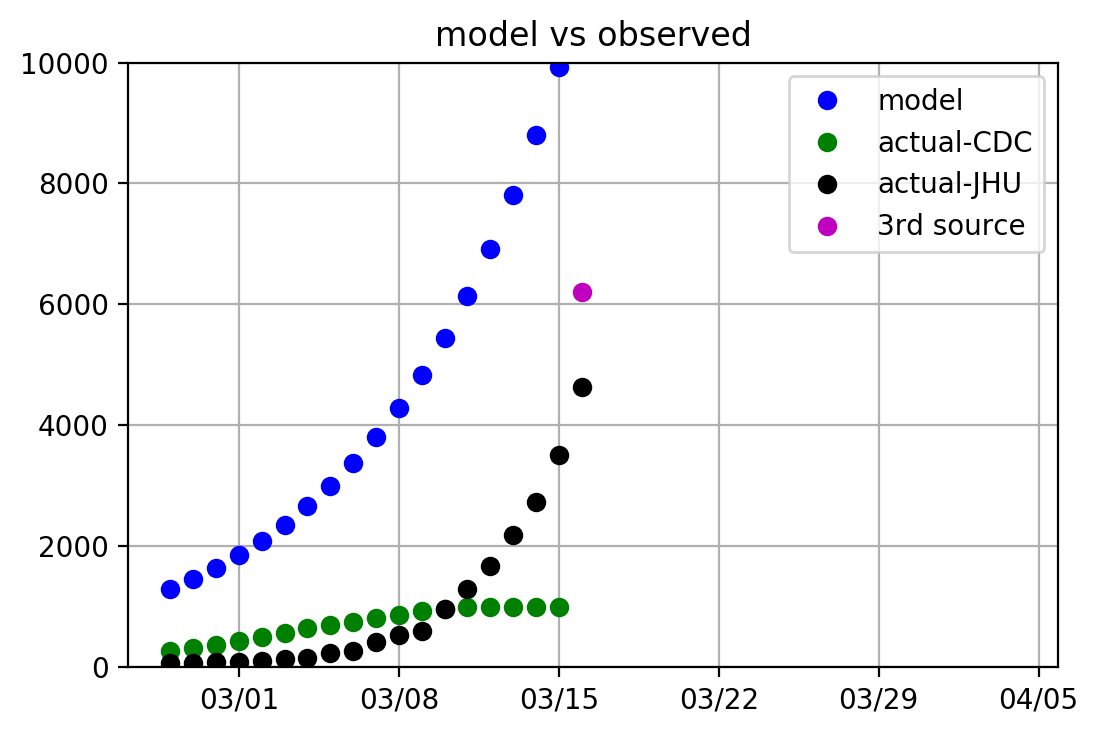

In [165]:
 #try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>250].index[0]
rate = .12

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-data.columns[-1] ).days-1


# projection (assume multipler of 5)
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))
yh=yh.astype(int)

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             data.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx[:, :, :, "USA"],"cases"].sum(),
            label="3rd source")

ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")
ax.set_ylim(0, 10000)


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([data.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])


if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    #this is wrong
    #df.loc[datetime.date.today(),"3rd"] = dataCS.loc[idx[:, :, :, "USA"],"cases"].sum()
    print(df)






In [ ]:
#script for scraping HTML sites but does not work on java scripts, need to inspect and find source
import requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
#notes on soup are here: https://realpython.com/beautiful-soup-web-scraper-python/
#print(soup.prettify())
#res = soup.find("epi-curve")




In [ ]:
# JHNU - usa has a problem cities and states overlap
usStates="""
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
"""

US = usStates.split('\n')[1:-1]
#data.loc[(US)]
sp.size(US)
#usStates.split('\n')[1:-1]
#US = list(set(data.index.levels[3])&set(US))
print(data.loc[("US",slice(None),slice(None),US)].sum()[-1])
print(data.loc["US"].sum()[-1])
#data.filter(like=',',axis=0)
#data.loc["US"]
#data.loc["US"]
#data.loc[("US",slice(None),slice(None), lambda df.: df.index.levels[3].str.contains(','))]
